In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import pearsonr, spearmanr, chi2_contingency, zscore, shapiro, ttest_ind
pd.set_option('display.max_columns', None)
from statsmodels.stats.proportion import proportions_ztest



In [2]:
df_raw = pd.read_csv(r"/Users/muayadhilamia/Desktop/Ironhack/Week-5/Project/week5_6_project/data/cleaned/df_cleand_raw_m.csv")

                    --- Cleaning and sorting

In [3]:
# making copy to avoid errors 
df = df_raw.copy()

# deleting "Unnamed" column 
if 'Unnamed: 0' in df.columns:
    df = df.drop(columns=['Unnamed: 0'])

# dropping nulls in "Variation"
df = df[df['Variation'].notna() & (df['Variation'] != "")]

# columns i want them to be intger 
int_cols = [
    'client_id', 'clnt_tenure_yr', 'clnt_tenure_mnth', 
    'clnt_age', 'num_accts', 'calls_6_mnth', 'logons_6_mnth',
    'num_steps', 'num_visits', 'total_steps', 'step_repeat_count', 'step_diff', "time_from_prev_step"
]
for col in int_cols:
    if col in df.columns:
        df[col] = pd.to_numeric(df[col], errors='coerce').astype('Int64')

# making "bal" float and round it 
if 'bal' in df.columns:
    df['bal'] = pd.to_numeric(df['bal'], errors='coerce').round(2)

# fixing date_time column 
if 'date_time' in df.columns:
    df['date_time'] = pd.to_datetime(df['date_time'], errors='coerce')

# dropping duplicates 
df = df.drop_duplicates()

# sorting by client, visit and date_time
df = df.sort_values(
    by=['client_id', 'visit_id', 'date_time'],
    ascending=[True, True, True]
)


                        --- Complete and Error rate 

In [36]:
# Total visits per group
total_visits = df.groupby(['Variation'])['visit_id'].nunique()

# Error rate per visit (based on total_errors per visit)
error_rate_per_visit = total_errors / total_visits

print("\nError Rate per visit (based on total errors):\n", error_rate_per_visit)


Error Rate per visit (based on total errors):
 Variation
Control    0.302153
Test       0.441378
dtype: float64


In [34]:
# Complete Rate Calculation

# 1. KEEP LAST STEP PER VISIT 
df_last_visit = df.drop_duplicates(subset="visit_id", keep="last")

# Group by 
completion_rate = df_last_visit.groupby('Variation')['completed'].mean()

print("Completion Rate per group:\n", completion_rate)

Completion Rate per group:
 Variation
Control    0.498257
Test       0.584815
Name: completed, dtype: float64


                    --- Hypothsis testing

In [37]:
# ---------- 5. GROUP SPLITTING ----------
test_group_last = df_last_visit[df_last_visit['Variation'] == 'Test']
control_group_last = df_last_visit[df_last_visit['Variation'] == 'Control']

test_group_err = errors_per_visit[errors_per_visit['Variation'] == 'Test']
control_group_err = errors_per_visit[errors_per_visit['Variation'] == 'Control']

# ---------- 6. Z-TESTS FOR PROPORTIONS ----------
# Completion Rate
completion_counts = [
    test_group_last['completed'].sum(),
    control_group_last['completed'].sum()
]
completion_n = [
    len(test_group_last),
    len(control_group_last)
]
z_stat_comp, p_val_comp = proportions_ztest(
    count=completion_counts,
    nobs=completion_n,
    alternative='larger'  # one-sided: Test > Control
)

# Error Rate
error_counts = [
    test_group_err['has_error'].sum(),
    control_group_err['has_error'].sum()
]
error_n = [
    len(test_group_err),
    len(control_group_err)
]
z_stat_err, p_val_err = proportions_ztest(
    count=error_counts,
    nobs=error_n,
    alternative='smaller'  # one-sided: Test < Control
)

print("Completion Rate - Z-statistic:", round(z_stat_comp, 3))
print("Completion Rate - P-value:", round(p_val_comp, 4))

print("\nError Rate - Z-statistic:", round(z_stat_err, 3))
print("Error Rate - P-value:", round(p_val_err, 4))
print("*" * 50)

# ---------- 7. DECISION MAKING ----------
alpha = 0.05

# Completion Rate
if p_val_comp < alpha:
    print("\n Test group has significantly higher completion rate than Control.")
else:
    print("\n❌No statistical evidence that Test performed better in completion rate.")

# Error Rate
if p_val_err < alpha:
    print("Test group has significantly lower error rate than Control.")
else:
    print("No statistical evidence that Test had fewer errors than Control.")

Completion Rate - Z-statistic: 22.803
Completion Rate - P-value: 0.0

Error Rate - Z-statistic: 19.978
Error Rate - P-value: 1.0
**************************************************

 Test group has significantly higher completion rate than Control.
No statistical evidence that Test had fewer errors than Control.


                    --- Step duration and hypothsis testing without outliers
                


📊 T-Test Results (Mean-Based):
      step  test_mean  control_mean  mean_diff  p_value  significant
0  Confirm     112.20        124.19      11.99   0.0000         True
1    Start      60.15         54.74      -5.41   0.9986        False
2   Step 1      37.49         42.76       5.27   0.0000         True
3   Step 2      48.01         38.59      -9.41   1.0000        False
4   Step 3      96.34         93.44      -2.91   0.9959        False

🔍 Significant improvements (Test group faster):
✅ Confirm: Test faster by 11.99s (p = 0.0)
✅ Step 1: Test faster by 5.27s (p = 0.0)


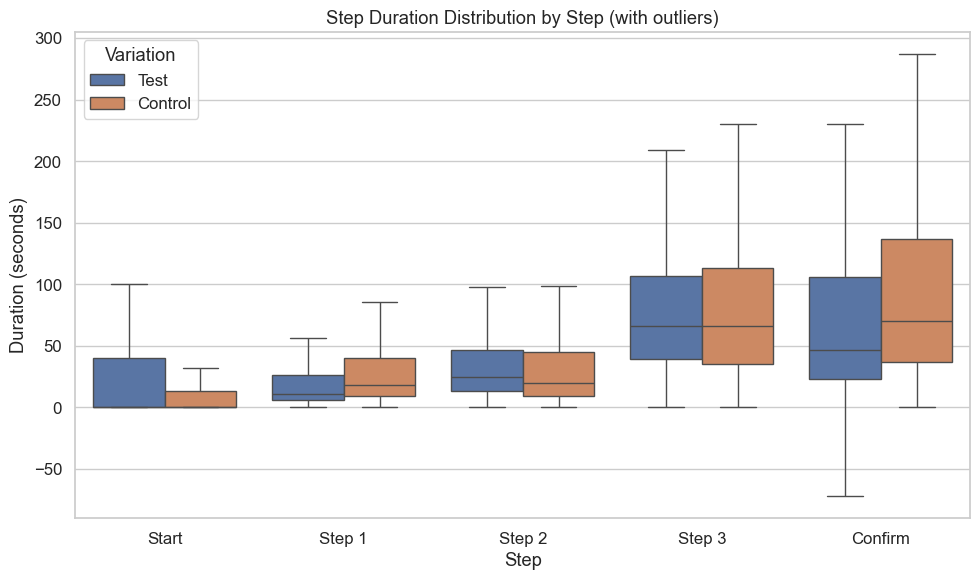

In [40]:


# ---------- STEP 1: Prepare step durations ----------
df_steps = df.copy()
df_steps['step_duration'] = df_steps['time_from_prev_step'].fillna(0)

step_labels = {
    1: "Start",
    2: "Step 1",
    3: "Step 2",
    4: "Step 3",
    5: "Confirm"
}
df_steps['step_label'] = df_steps['process_step'].map(step_labels)

# ---------- STEP 2: T-tests (based on mean) ----------
results = []

for step in sorted(df_steps['step_label'].dropna().unique()):
    test = df_steps[(df_steps['Variation'] == 'Test') & (df_steps['step_label'] == step)]['step_duration']
    control = df_steps[(df_steps['Variation'] == 'Control') & (df_steps['step_label'] == step)]['step_duration']
    
    t_stat, p_val = ttest_ind(test, control, alternative='less')

    results.append({
        'step': step,
        'test_mean': round(test.mean(), 2),
        'control_mean': round(control.mean(), 2),
        'mean_diff': round(control.mean() - test.mean(), 2),  # Positive = Test is faster
        'p_value': round(p_val, 4),
        'significant': p_val < 0.05
    })

results_df = pd.DataFrame(results)

# ---------- STEP 3: Show results ----------
print("\n📊 T-Test Results (Mean-Based):")
print(results_df)

print("\n🔍 Significant improvements (Test group faster):")
sig = results_df[results_df['significant']]
if not sig.empty:
    for _, row in sig.iterrows():
        print(f"✅ {row['step']}: Test faster by {row['mean_diff']}s (p = {row['p_value']})")
else:
    print("❌ No significant improvements found.")

# ---------- STEP 4: Boxplot ----------
sns.set(style="whitegrid", font_scale=1.1)
plt.figure(figsize=(10, 6))
sns.boxplot(
    data=df_steps,
    x="step_label",
    y="step_duration",
    hue="Variation",
    showfliers=False
)
plt.title("Step Duration Distribution by Step (with outliers)")
plt.xlabel("Step")
plt.ylabel("Duration (seconds)")
plt.legend(title="Variation")
plt.tight_layout()
plt.show()

/var/folders/lt/yxd_bdjs4fn9bd90z539wlsm0000gn/T/ipykernel_7497/2392026829.py:33: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(remove_outliers_iqr)


✅ Removed 37649 outliers using IQR.

📊 T-Test Results (Mean-Based, After IQR Filtering):
      step  test_mean  control_mean  mean_diff  p_value  significant
0  Confirm      55.68         79.95      24.27   0.0000         True
1    Start      11.69          2.02      -9.68   1.0000        False
2   Step 1      12.81         22.39       9.58   0.0000         True
3   Step 2      28.27         26.01      -2.26   1.0000        False
4   Step 3      69.98         71.73       1.74   0.0001         True

🔍 Significant improvements (Test group faster):
✅ Confirm: Test faster by 24.27s (p = 0.0)
✅ Step 1: Test faster by 9.58s (p = 0.0)
✅ Step 3: Test faster by 1.74s (p = 0.0001)


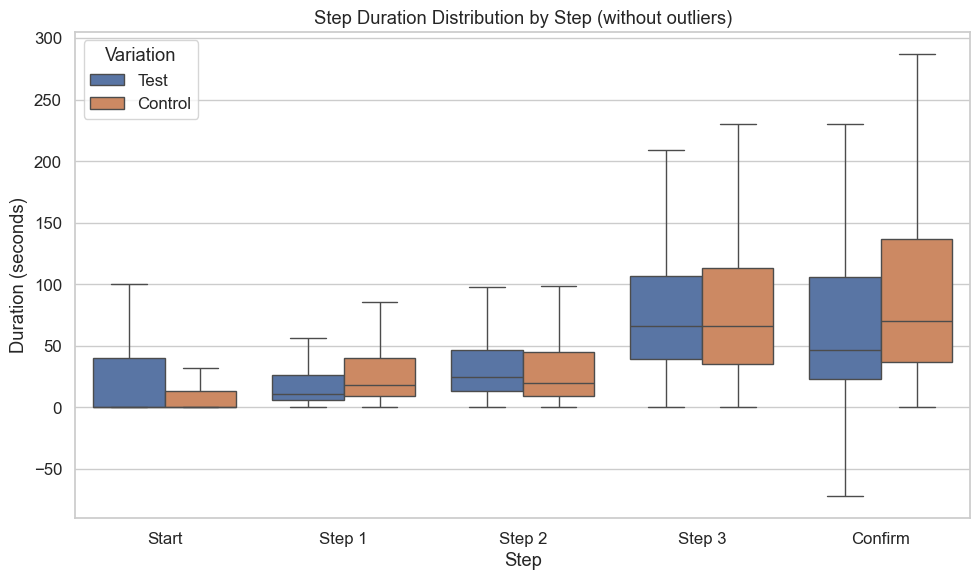

In [41]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import ttest_ind

# ---------- STEP 1: Prepare step durations ----------
df_steps = df.copy()
df_steps['step_duration'] = df_steps['time_from_prev_step'].fillna(0)

# Map process steps to readable labels
step_labels = {
    1: "Start",
    2: "Step 1",
    3: "Step 2",
    4: "Step 3",
    5: "Confirm"
}
df_steps['step_label'] = df_steps['process_step'].map(step_labels)

# ---------- STEP 2: Remove outliers using IQR ----------
def remove_outliers_iqr(group):
    q1 = group['step_duration'].quantile(0.25)
    q3 = group['step_duration'].quantile(0.75)
    iqr = q3 - q1
    lower = q1 - 1.5 * iqr
    upper = q3 + 1.5 * iqr
    return group[(group['step_duration'] >= lower) & (group['step_duration'] <= upper)]

# Apply IQR filter per Variation & Step
filtered_df = (
    df_steps
    .groupby(['Variation', 'step_label'], group_keys=False)
    .apply(remove_outliers_iqr)
)

print(f"✅ Removed {len(df_steps) - len(filtered_df)} outliers using IQR.")

# ---------- STEP 3: T-tests (mean comparison after outlier removal) ----------
results = []

for step in sorted(filtered_df['step_label'].dropna().unique()):
    test = filtered_df[(filtered_df['Variation'] == 'Test') & (filtered_df['step_label'] == step)]['step_duration']
    control = filtered_df[(filtered_df['Variation'] == 'Control') & (filtered_df['step_label'] == step)]['step_duration']
    
    t_stat, p_val = ttest_ind(test, control, alternative='less')

    results.append({
        'step': step,
        'test_mean': round(test.mean(), 2),
        'control_mean': round(control.mean(), 2),
        'mean_diff': round(control.mean() - test.mean(), 2),  # Positive = Test is faster
        'p_value': round(p_val, 4),
        'significant': p_val < 0.05
    })

results_df = pd.DataFrame(results)

# ---------- STEP 4: Show results ----------
print("\n📊 T-Test Results (Mean-Based, After IQR Filtering):")
print(results_df)

print("\n🔍 Significant improvements (Test group faster):")
sig = results_df[results_df['significant']]
if not sig.empty:
    for _, row in sig.iterrows():
        print(f"✅ {row['step']}: Test faster by {row['mean_diff']}s (p = {row['p_value']})")
else:
    print("❌ No significant improvements found.")

# ---------- STEP 5: Boxplot (after outlier removal) ----------
sns.set(style="whitegrid", font_scale=1.1)
plt.figure(figsize=(10, 6))
sns.boxplot(
    data=df_steps,
    x="step_label",
    y="step_duration",
    hue="Variation",
    showfliers=False
)
plt.title("Step Duration Distribution by Step (without outliers)")
plt.xlabel("Step")
plt.ylabel("Duration (seconds)")
plt.legend(title="Variation")
plt.tight_layout()
plt.show()